<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/ModNet/SD_Lora_Dreambost/DZ_2_Lora_SD_fintune_on_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Модуль 2. Диффузионные модели. Часть 2
## Домашнее задание: реализация обучения диффузионной модели

###Цель домашнего занятия
Научиться реализовывать обучение диффузии под датасет и решить задачу Image Inpainting с помощью HuggingFace, PyTorch, Pytorch Lightning.

# [6 баллов] Дообучение диффузионной модели.

В этом задании вам предстоит обучить диффузионную модель для решения задачи text-to-image. В предыдущем задании вы уже обучали диффузионную модель, но она была unconditional, то есть генерировала без каких-либо условий. В этот раз вам предлагается обучить свою text-to-image модель на датасете https://huggingface.co/datasets/Norod78/cartoon-blip-captions или на другом понравившемся датасете

---

В этой части задания вам рекомендуется взять код с семинара 4 и адаптировать его под обучение на новом датасете, с учетом того, что в нём содержатся картинки

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели, а также визуальное сравнение качества моделей до и после дообучения. Если не получится дообучить, то можно провести сравнение уже обученных адаптеров (3 балла).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U datasets # diffusers accelerate transformers huggingface_hub #triton ftfy bitsandbytes gradio natsort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, concatenate_datasets

dataset = load_dataset("Norod78/cartoon-blip-captions")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 3141
    })
})

## View dataset

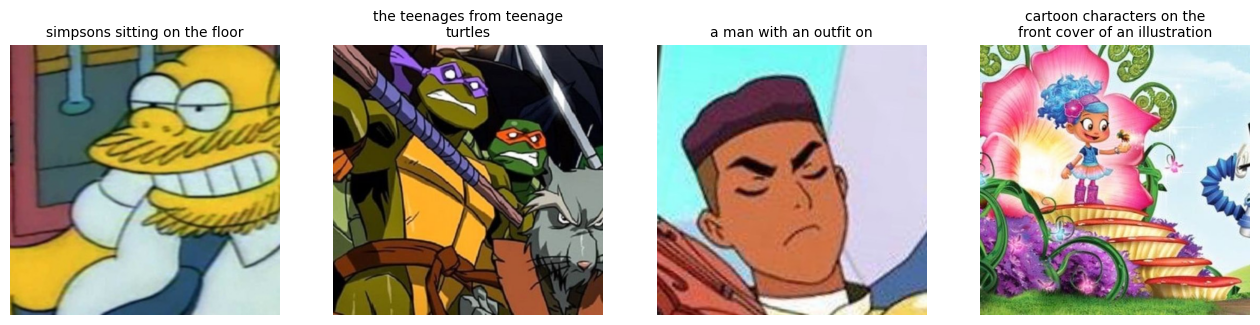

In [ ]:
import matplotlib.pyplot as plt
from textwrap import wrap
import numpy as np

inds = np.random.randint(1, len(dataset['train']), 4)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
#for i, (image, text) in enumerate(zip(dataset['train']['image'][:4], dataset['train']['text'][:4])):
for i, (image, text) in enumerate(zip(dataset['train'][inds]['image'], dataset['train'][inds]['text'])):
    axs[i].imshow(image)
    axs[i].set_title("\n".join(wrap(text, 30)), fontsize=10)
    axs[i].set_axis_off()
fig.show()

In [ ]:
from huggingface_hub import login

login()

https://huggingface.co/docs/diffusers/training/text2image

Модели преобразования текста в изображение, такие как Stable Diffusion, генерируют изображение из текстовой подсказки. В этом руководстве мы покажем вам, как произвести тонкую настройку модели CompVis/stable-diffusion-v1-4 на вашем собственном наборе данных с помощью PyTorch и Flax. Все обучающие скрипты для тонкой настройки модели "текст-изображение", используемые в данном руководстве, можно найти в этом репозитории, если вам интересно взглянуть на них поближе.

Перед запуском скриптов обязательно установите зависимости библиотеки для обучения:

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/text_to_image/train_text_to_image_lora.py -q
!pip install git+https://github.com/huggingface/diffusers -q

!wget https://github.com/huggingface/diffusers/raw/main/examples/text_to_image/requirements.txt -q
!pip install -U -r requirements.txt -q

Если вы уже клонировали репозиторий, то вам не нужно выполнять эти шаги. Вместо этого можно передать обучающему скрипту путь к локальной кассе, и он будет загружен оттуда.

## Fine-tuning
https://harrywang.me/sd


https://aituts.com/stable-diffusion-lora/#generating-sample-images

https://huggingface.co/blog/lora

Запустите обучающий скрипт PyTorch для тонкой настройки на наборе данных Pokémon BLIP captions следующим образом.

Укажите переменную окружения MODEL_NAME (либо идентификатор репозитория модели Hub, либо путь к каталогу с весами модели) и передайте ее в аргумент pretrained_model_name_or_path.

In [ ]:
from huggingface_hub import model_info

# Веса LoRA ~3 МБ
model_path = "runwayml/stable-diffusion-v1-5" #"sayakpaul/sd-model-finetuned-lora-t4"

info = model_info(model_path)
model_base = info.cardData#["base_model"]
model_base # CompVis/stable-diffusion-v1-4

{'license': 'creativeml-openrail-m',
 'tags': ['stable-diffusion', 'stable-diffusion-diffusers', 'text-to-image'],
 'inference': True,
 'extra_gated_prompt': "This model is open access and available to all, with a CreativeML OpenRAIL-M license further specifying rights and usage.\nThe CreativeML OpenRAIL License specifies: \n\n1. You can't use the model to deliberately produce nor share illegal or harmful outputs or content \n2. CompVis claims no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in the license\n3. You may re-distribute the weights and use the model commercially and/or as a service. If you do, please be aware you have to include the same use restrictions as the ones in the license and share a copy of the CreativeML OpenRAIL-M to all your users (please read the license entirely and carefully)\nPlease read the full license carefully here: https://huggingface.co/spaces/CompVis/stable-

И инициализировать среду Accelerate с:

In [ ]:
!accelerate config default

In [ ]:
BASE_PATH = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/SD_train_DZ'
path_dir = BASE_PATH + '/Lora_finetune'

In [ ]:
!export MODEL_NAME="runwayml/stable-diffusion-v1-5"
!export DATA_DIR="Norod78/cartoon-blip-captions"
!export OUTPUT_DIR=path_dir

In [ ]:
!accelerate launch --mixed_precision="fp16"  train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="Norod78/cartoon-blip-captions" \
  --dataloader_num_workers=8 \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=2500 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir='/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/SD_train_DZ/Lora_finetune' \
  --checkpointing_steps=500 \
  --validation_prompt="Mickey Mouse playing socker with Uncle Duck and president Abama" \
  --validation_epochs=10 \
  --seed=42


По окончании обучения модель будет сохранена в указанном в команде output_dir. В данном примере это sd-pokemon-model. Чтобы загрузить настроенную модель для вывода, просто передайте этот путь в StableDiffusionPipeline

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

prj_path = BASE_PATH + '/Lora_finetune'
model = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
model,
torch_dtype=torch.float16,
)
pipe.to("cuda")
#pipeline.unet.set_attn_processor(AttnProcessor2_0())
pipe.load_lora_weights(prj_path, weight_name="pytorch_lora_weights.safetensors")

PROMPT = "Mickey Mouse playing socker with duck and bear"

seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
images = pipe(prompt=PROMPT,
             num_inference_steps=15,
             num_images_per_prompt=4,
             generator=generator)#.images[0]
#image.save(f"generated_image.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
You have saved the LoRA weights using the old format. To convert the old LoRA weights to the new format, you can first load them in a dictionary and then create a new dictionary like the following: `new_state_dict = {f'unet.{module_name}': params for module_name, params in old_state_dict.items()}`.


  0%|          | 0/15 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [ ]:
images['images']

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [ ]:
PROMPT = "One Donald Duck and one Mickey Mouse playing together in tenis"
negative_prompt = ("(low quality, worst quality:1.4), (bad anatomy), (inaccurate limb:1.2), "
                   "bad composition, inaccurate eyes, extra digit, fewer digits, (extra arms:1.2), large breasts")
seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
images = pipe(prompt=PROMPT,
             negative_prompt=negative_prompt,
             num_inference_steps=50,
             num_images_per_prompt=4,
             generator=generator)#.images[0]
#image.save(f"generated_image.png")

  0%|          | 0/50 [00:00<?, ?it/s]

##Визулизации

In [ ]:
import glob
def make_gif(set_dir_pil, out_name = "my_awesome.gif", duration = 10, loop=0, ext = '/*.JPG'):
    import PIL
    if type(set_dir_pil) == str:
       frames = [PIL.Image.open(image) for image in glob.glob(f"{set_dir_pil}{ext}")]
    elif type(set_dir_pil) == list: frames = set_dir_pil

    frame_one = frames[0]
    frame_one.save(out_name, format="GIF", append_images=frames,
               save_all=True, duration=duration, loop=loop)


def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

### Lora_pipe


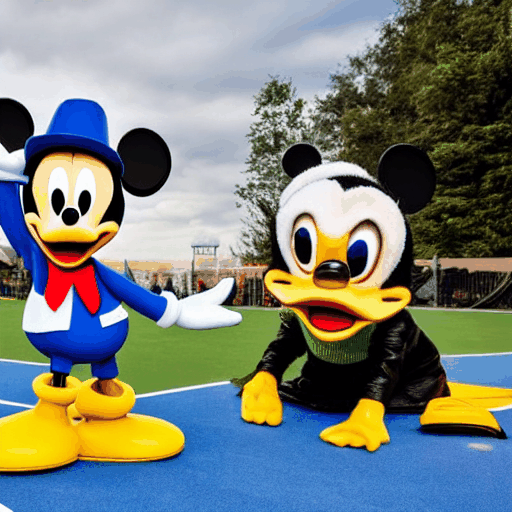

In [ ]:
OUT_DIR = f"{BASE_PATH}/Lora_finetune/movie.gif"
make_gif(set_dir_pil = images['images'],
         out_name = OUT_DIR,
         duration = 1000,
         loop = 0,
         )

show_gif(OUT_DIR)

## Orig_pipe

In [ ]:
orig_pipe = StableDiffusionPipeline.from_pretrained(
model,
torch_dtype=torch.float16,
)
orig_pipe.to("cuda")

seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
images = orig_pipe(prompt=PROMPT,
             num_inference_steps=15,
             num_images_per_prompt=4,
             generator=generator)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/15 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.



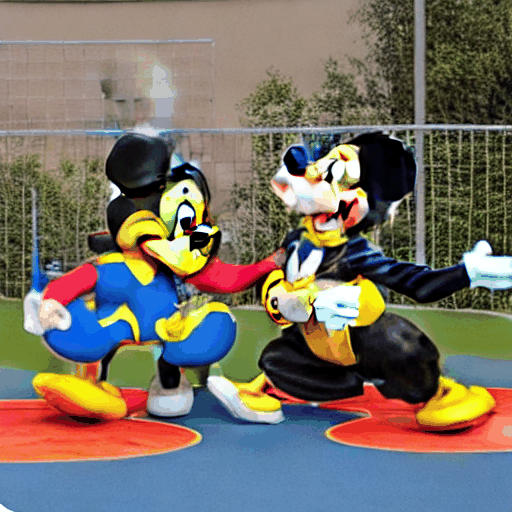

In [ ]:
OUT_DIR = f"{BASE_PATH}/Lora_finetune/movie_oirig.gif"
make_gif(set_dir_pil = images['images'],
         out_name = OUT_DIR,
         duration = 1000,
         loop = 0,
         )

show_gif(OUT_DIR)

## Вывод
В оригинальной модели не достаточно информации для хорошей генерации из того же промпта.
Даже на малом обучении через Lora генерация значительно лучше